In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# Dataset class for arithmetic problems
class ArithmeticDataset(Dataset):
    def __init__(self, max_length=20, num_samples=1000):
        self.max_length = max_length
        self.num_samples = num_samples
        # Vocabulary: 0-9 for digits, 10 for '+', 11 for '=', 12 for padding, 13 for EOS
        self.vocab = {str(i): i for i in range(10)}
        self.vocab.update({'+': 10, '=': 11, '<PAD>': 12, '<EOS>': 13})
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.data = self.generate_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def generate_number(self, length):
        return random.randint(10**(length-1), 10**length - 1)

    def tokenize(self, s):
        return [self.vocab[c] for c in s if c in self.vocab]

    def pad_sequence(self, seq, max_length):
        return seq + [self.vocab['<PAD>']] * (max_length - len(seq))

    def decode(self, tensor):
        return ''.join(self.inv_vocab[t.item()] for t in tensor if t.item() not in 
                      [self.vocab['<PAD>'], self.vocab['<EOS>']])[::-1]

    def generate_data(self):
        data = []
        samples_per_combination = max(1, self.num_samples // (self.max_length ** 2))
        
        for i in range(1, self.max_length + 1):
            for j in range(1, self.max_length + 1):
                for _ in range(samples_per_combination):
                    num1 = self.generate_number(i)
                    num2 = self.generate_number(j)
                    result = num1 + num2
                    
                    # Create reversed input string
                    input_str = f"{num1}+{num2}="
                    input_str = input_str[::-1]
                    
                    # Create reversed target string
                    target_str = f"{result}"[::-1]
                    
                    # Tokenize and pad
                    input_tokens = self.tokenize(input_str)
                    target_tokens = self.tokenize(target_str) + [self.vocab['<EOS>']]
                    max_seq_length = self.max_length * 2 + 2
                    
                    input_padded = self.pad_sequence(input_tokens, max_seq_length)
                    target_padded = self.pad_sequence(target_tokens, max_seq_length)
                    
                    # Convert to tensors
                    input_tensor = torch.tensor(input_padded, dtype=torch.long)
                    target_tensor = torch.tensor(target_padded, dtype=torch.long)
                    data.append((input_tensor, target_tensor))
        
        return data

In [9]:
# Model Architecture Components
class AbacusEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, max_length):
        super().__init__()
        # Create an embedding layer for the input tokens
        self.embed = nn.Embedding(vocab_size, embed_size)
        # Create a separate embedding layer for positional encodings
        self.pos_embed = nn.Embedding(max_length, embed_size)
        self.max_length = max_length
        
    def forward(self, x):
        # Get the sequence length of the input
        seq_length = x.size(1)
        
        # Generate position indices
        pos = torch.arange(seq_length, device=x.device).unsqueeze(0)
        
        # Truncate positions to max_length
        # This ensures that positions beyond max_length use the same embedding
        pos = torch.clamp(pos, max=self.max_length - 1)
        
        # Get the token embeddings
        embedded = self.embed(x)
        
        # Get the positional embeddings
        positional = self.pos_embed(pos)
        
        # Combine token embeddings and positional embeddings
        return embedded + positional[:, :seq_length]
    
class SmallTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, ff_dim, num_layers, max_length):
        super().__init__()
        # Initialize the custom Abacus Embedding layer
        self.embedding = AbacusEmbedding(vocab_size, embed_size, max_length)
        
        # Create a single Transformer encoder layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True
        )
        
        # Create the full Transformer encoder by stacking multiple layers
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        
        # Final linear layer to project to vocabulary size
        self.fc_out = nn.Linear(embed_size, vocab_size)
        
    def forward(self, x):
        try:
            # Apply Abacus Embedding
            x = self.embedding(x)
            
            # Pass through the Transformer encoder
            x = self.transformer(x)
            
            # Project to vocabulary size
            return self.fc_out(x)
        except Exception as e:
            print(f"Error in SmallTransformer forward pass: {str(e)}")
            raise e

In [10]:
# Function to load a given model
def load_arithmetic_model(model_path):
    # Load the saved model
    checkpoint = torch.load(model_path)

    # Recreate the model architecture
    model = SmallTransformer(
        checkpoint['vocab_size'],
        checkpoint['embed_size'],
        checkpoint['num_heads'],
        checkpoint['ff_dim'],
        checkpoint['num_layers'],
        checkpoint['max_seq_length']
    )

    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

# Test function for trying an addition problems
def test_addition(model, dataset, num1, num2):
    """Test the model on a specific addition problem"""
    # Create input string in the same format as training data
    input_str = f"{num1}+{num2}="
    input_str = input_str[::-1]  # Reverse the string
    
    # Tokenize and pad
    input_tokens = dataset.tokenize(input_str)
    max_seq_length = dataset.max_length * 2 + 2
    input_padded = dataset.pad_sequence(input_tokens, max_seq_length)
    input_tensor = torch.tensor([input_padded], dtype=torch.long)
    
    # Generate prediction
    with torch.no_grad():
        output = model(input_tensor)
        predicted = torch.argmax(output, dim=-1)
        result = dataset.decode(predicted[0])
    
    print(f"\nInput: {num1} + {num2} = ?")
    print(f"True result: {num1 + num2}")
    print(f"Model prediction: {result}")
    print(f"Correct: {int(result) == num1 + num2}")


In [11]:
# Load model
loaded_model = load_arithmetic_model('trained_addition_model.pth')
    
# Create dataset instance
dataset = ArithmeticDataset(max_length=20, num_samples=200_000)

# Test cell - try a few addition problems
test_addition(loaded_model, dataset, 123, 456)
#test_addition(loaded_model, dataset, 45, 67)
#test_addition(loaded_model, dataset, 1234, 5678)


Input: 123 + 456 = ?
True result: 579
Model prediction: 579
Correct: True


Running basic embedding analyses...


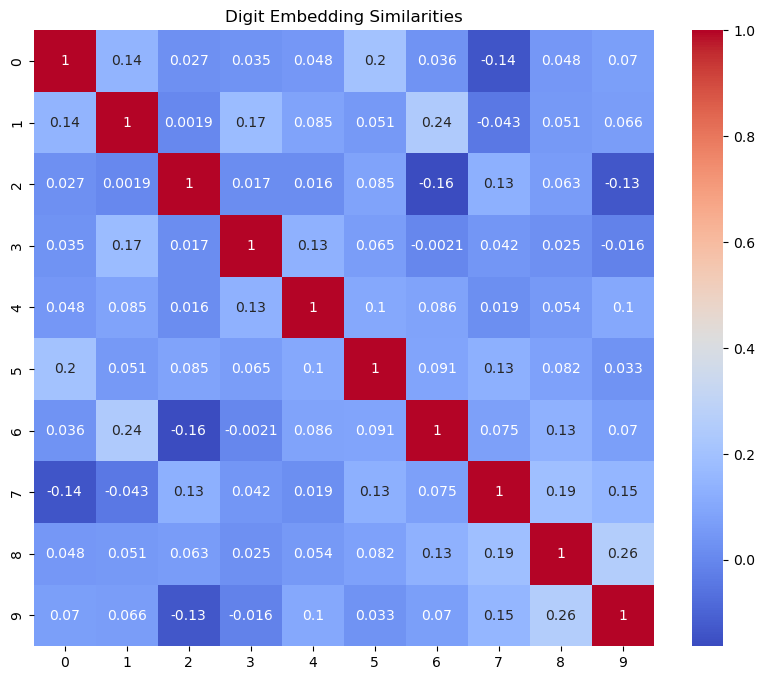

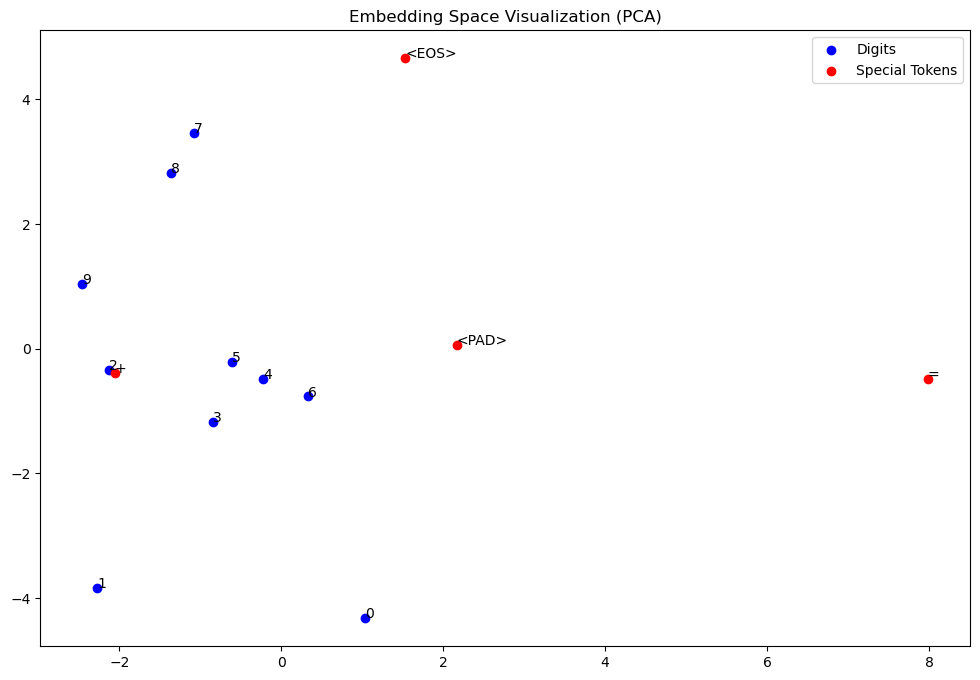

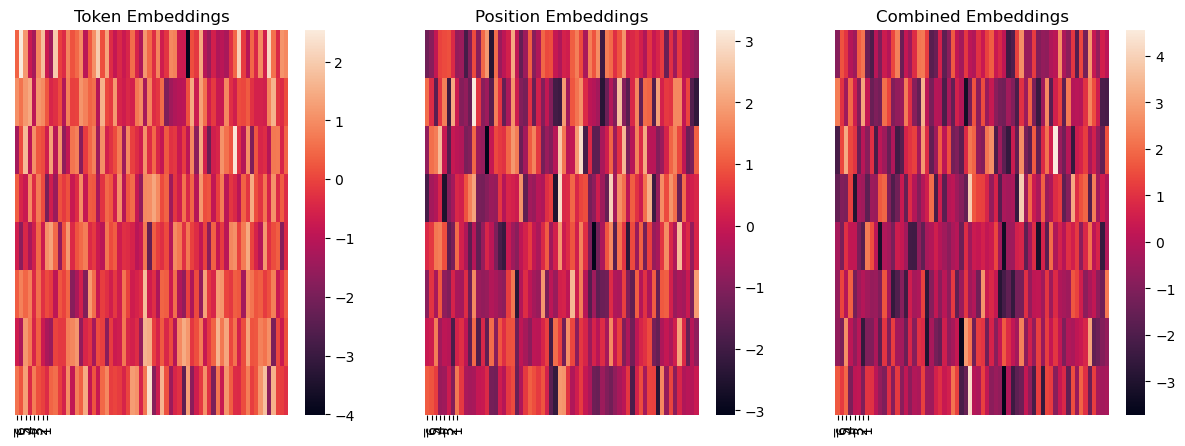


Analyzing position 0 similarities:
Positions most similar to position 0: [(0, 0.9999999403953552), (1, 0.2702123522758484), (11, 0.21617603302001953)]

Comparing digit embeddings across positions:


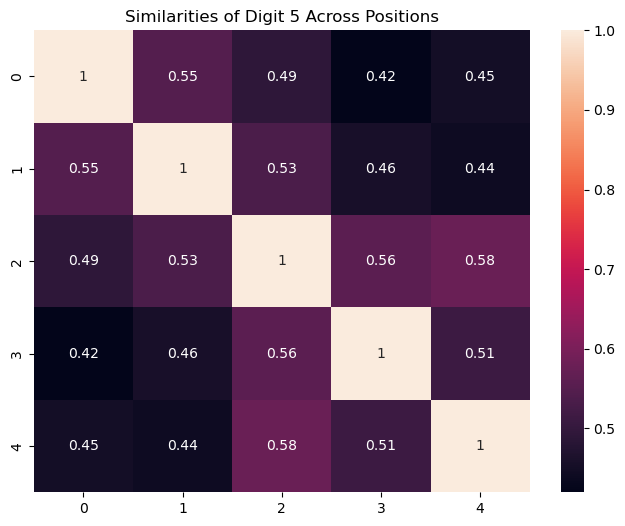

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns

class EmbeddingAnalyzer:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.device = next(model.parameters()).device
        
    def get_token_embeddings(self):
        """Get the raw token embeddings"""
        return self.model.embedding.embed.weight.detach()
    
    def get_positional_embeddings(self):
        """Get the positional embeddings"""
        return self.model.embedding.pos_embed.weight.detach()
    
    def plot_digit_similarities(self):
        """Plot similarity matrix between digit embeddings"""
        # Get only digit embeddings (0-9)
        digit_embeddings = self.get_token_embeddings()[:10]
        
        # Compute cosine similarities
        similarities = F.cosine_similarity(digit_embeddings.unsqueeze(0),
                                        digit_embeddings.unsqueeze(1),
                                        dim=2)
        
        # Create heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(similarities.numpy(), 
                   annot=True, 
                   xticklabels=range(10),
                   yticklabels=range(10),
                   cmap='coolwarm')
        plt.title('Digit Embedding Similarities')
        plt.show()
    
    def plot_embedding_space_2d(self, method='pca'):
        """Plot 2D visualization of the embedding space"""
        from sklearn.decomposition import PCA
        from sklearn.manifold import TSNE
        
        # Get all embeddings
        embeddings = self.get_token_embeddings()
        
        # Reduce dimensionality
        if method == 'pca':
            reducer = PCA(n_components=2)
        else:
            reducer = TSNE(n_components=2)
            
        reduced = reducer.fit_transform(embeddings.numpy())
        
        # Plot
        plt.figure(figsize=(12, 8))
        # Plot digits
        plt.scatter(reduced[:10, 0], reduced[:10, 1], c='blue', label='Digits')
        for i in range(10):
            plt.annotate(str(i), (reduced[i, 0], reduced[i, 1]))
        
        # Plot special tokens
        plt.scatter(reduced[10:, 0], reduced[10:, 1], c='red', label='Special Tokens')
        special_tokens = ['+', '=', '<PAD>', '<EOS>']
        for i, token in enumerate(special_tokens):
            plt.annotate(token, (reduced[10+i, 0], reduced[10+i, 1]))
        
        plt.title(f'Embedding Space Visualization ({method.upper()})')
        plt.legend()
        plt.show()
    
    def analyze_positional_patterns(self):
        """Analyze how position affects digit embeddings"""
        # Get a simple addition problem
        num1, num2 = 123, 456
        input_str = f"{num1}+{num2}="
        input_str = input_str[::-1]
        
        # Get token and position embeddings
        tokens = torch.tensor([self.dataset.tokenize(input_str)]).to(self.device)
        token_emb = self.model.embedding.embed(tokens)
        pos_emb = self.model.embedding.pos_embed(torch.arange(len(input_str)).to(self.device))
        
        # Plot contribution of positional embeddings
        plt.figure(figsize=(15, 5))
        
        # Token embeddings magnitude
        plt.subplot(131)
        sns.heatmap(token_emb[0].cpu().detach().numpy(),
                   xticklabels=list(input_str),
                   yticklabels=False)
        plt.title('Token Embeddings')
        
        # Position embeddings magnitude
        plt.subplot(132)
        sns.heatmap(pos_emb.cpu().detach().numpy(),
                   xticklabels=list(input_str),
                   yticklabels=False)
        plt.title('Position Embeddings')
        
        # Combined embeddings
        plt.subplot(133)
        sns.heatmap((token_emb[0] + pos_emb).cpu().detach().numpy(),
                   xticklabels=list(input_str),
                   yticklabels=False)
        plt.title('Combined Embeddings')
        plt.show()
    
    def find_similar_positions(self, position_idx, top_k=3):
        """Find positions with similar embeddings"""
        pos_embeddings = self.get_positional_embeddings()
        query_embedding = pos_embeddings[position_idx]
        
        similarities = F.cosine_similarity(query_embedding.unsqueeze(0), 
                                        pos_embeddings)
        values, indices = torch.topk(similarities, top_k)
        
        return [(idx.item(), sim.item()) for idx, sim in zip(indices, values)]
    
    def compare_digit_embeddings_across_positions(self, digit, positions):
        """Compare embeddings of the same digit at different positions"""
        token_idx = self.dataset.vocab[str(digit)]
        token_embedding = self.get_token_embeddings()[token_idx]
        pos_embeddings = self.get_positional_embeddings()[positions]
        
        combined_embeddings = token_embedding + pos_embeddings
        
        # Compute pairwise similarities
        similarities = F.cosine_similarity(combined_embeddings.unsqueeze(0),
                                        combined_embeddings.unsqueeze(1),
                                        dim=2)
        
        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(similarities.numpy(),
                   annot=True,
                   xticklabels=positions,
                   yticklabels=positions)
        plt.title(f'Similarities of Digit {digit} Across Positions')
        plt.show()

# Create analyzer instance
analyzer = EmbeddingAnalyzer(loaded_model, dataset)

# Basic analysis examples
print("Running basic embedding analyses...")
analyzer.plot_digit_similarities()
analyzer.plot_embedding_space_2d(method='pca')
analyzer.analyze_positional_patterns()

# Position-specific analysis
print("\nAnalyzing position 0 similarities:")
similar_positions = analyzer.find_similar_positions(0, top_k=3)
print(f"Positions most similar to position 0: {similar_positions}")

# Compare digit embeddings across positions
print("\nComparing digit embeddings across positions:")
analyzer.compare_digit_embeddings_across_positions(digit=5, positions=[0,1,2,3,4])